## *Этап - Feature engineering и построение модели*

#### Импорт библиотек

Для работы с датафреймом использовал стандартые библиотеки: pandas, numpy, matplotlib, seaborn). При построении модели пользовался библиотекой sklearn.

Для сохранения полученной модели и использовании ее в следующем этапе импортировал библиотеку pickle.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

import pickle

In [2]:
df = pd.read_csv('database_with_district.csv', index_col=0)

In [3]:
# Переименовываю кололнки в удобные для работы названия
df = df.rename(columns={'balcony\loggia': 'balcony_or_loggia', 'Year built': 'Year_built'})

#### Обзор датафрейма
На первый взгляд, датасет имеет:
- 3253 строк и 10 колонок;
- NaN значения в колонках *balcony_or_loggia, Bathroom, Year_built*;
- возможно имеются дубликаты;
- возможно колонки имеют неподходящий тип данных.

In [4]:
df

,Price,Rooms,Area,Floor,Max_house_floor,balcony_or_loggia,Bathroom,Year_built,District,Link
0,3250000,2.0,40.0,9.0,25.0,балкон,совмещенный,2016.0,Орджоникидзевский,https://www.avito.ru/perm/kvartiry/2-k._kvarti...
1,7017200,2.0,58.8,20.0,25.0,балкон,раздельный,2021.0,Индустриальный,https://www.avito.ru/perm/kvartiry/2-k._kvarti...
2,7600000,2.0,60.0,14.0,25.0,NaN,раздельный,2013.0,Свердловский,https://www.avito.ru/perm/kvartiry/2-k._kvarti...
3,7500000,3.0,95.0,4.0,16.0,NaN,NaN,NaN,Дзержинский,https://www.avito.ru/perm/kvartiry/3-k._kvarti...
4,2399000,1.0,36.0,1.0,9.0,NaN,раздельный,1986.0,Свердловский,https://www.avito.ru/perm/kvartiry/1-k._kvarti...
...,...,...,...,...,...,...,...,...,...,...
3248,12000000,4.0,130.0,6.0,9.0,лоджия,раздельный,2005.0,Свердловский,https://www.avito.ru/perm/kvartiry/4-k._kvarti...
3249,3700000,2.0,43.2,7.0,9.0,лоджия,раздельный,NaN,Свердловский,https://www.avito.ru/perm/kvartiry/2-k._kvarti...
3250,2800000,3.0,57.8,2.0,4.0,NaN,раздельный,NaN,Кировский,https://www.avito.ru/perm/kvartiry/3-k._kvarti...
3251,4300000,3.0,68.0,9.0,10.0,балкон,раздельный,2000.0,Мотовилихинский,https://www.avito.ru/perm/kvartiry/3-k._kvarti...


#### Исключение дубликатов
Так как при парсинге я не исключал квартиры, которые могли дублироваться на соседних страницах, их  необходимо дропнуть.

In [5]:
print('Размерность датафрейма:')
print('  - до удаления дубликатов', df.shape)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
print('  - после удаления', df.shape)

Размерность датафрейма:
  - до удаления дубликатов (3253, 10)
  - после удаления (3093, 10)


#### Приведение признаков к соответствующему типу данных
Колонки *Price*, *Area* выдают ошибку при использовании метода `astype()`. При детальном рассмотреннии были выявлены неверно спарсированные данные в колонках:
1. *Price*: были включены квартиры без фиксированной цены в объявлении
1. *Disctrict*: включились неверные районы

После удаления дубликатов и строк с явными ошибками размер датасета составляет 3083х10

In [6]:
df.dtypes

Price                 object
Rooms                float64
Area                 float64
Floor                float64
Max_house_floor      float64
balcony_or_loggia     object
Bathroom              object
Year_built           float64
District              object
Link                  object
dtype: object

In [ ]:
df.astype({'Price': 'int64'})

#ValueError: invalid literal for int() with base 10: 'от3500000'

В колонке *Price* встречаются странные значения "от...". При детальном проходе по всем строкам колонки *Price* были выявлены аукционные объекты недвижимости, которые не должны были встретиться при парсинге. Необходимо их дропнуть.

In [7]:
indx = []
for i in range(len(df.Price)):
    try:
        int(df.Price[i])
    except:
        indx.append(i)
df.iloc[indx]        

,Price,Rooms,Area,Floor,Max_house_floor,balcony_or_loggia,Bathroom,Year_built,District,Link
67,от3500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Мотовилихинский,https://www.avito.ru/perm/kvartiry/auktsion_1-...
850,от11500000,NaN,NaN,NaN,NaN,лоджия,раздельный,2018.0,Дзержинский,https://www.avito.ru/perm/kvartiry/auktsion_2-...
1025,от11700000,NaN,NaN,NaN,NaN,лоджия,раздельный,2017.0,Свердловский,https://www.avito.ru/perm/kvartiry/auktsion_2-...
1194,от3200000,NaN,NaN,NaN,NaN,балкон,совмещенный,2013.0,Кировский,https://www.avito.ru/perm/kvartiry/auktsion_1-...
2141,от3070000,NaN,NaN,NaN,NaN,лоджия,совмещенный,NaN,Свердловский,https://www.avito.ru/perm/kvartiry/auktsion_2-...
2475,от2660000,2.0,43.3,5.0,5.0,балкон,раздельный,1969.0,Дзержинский,https://www.avito.ru/perm/kvartiry/2-k._kvarti...
2859,от3150000,NaN,NaN,NaN,NaN,лоджия,раздельный,2008.0,Дзержинский,https://www.avito.ru/perm/kvartiry/auktsion_1-...


In [8]:
df = df.drop(indx, axis=0)
df = df.reset_index(drop=True)

In [9]:
df = df.astype({'Price': 'int64'})

В колонку *District* добавился район под именем города у 3 объектов. Необходимо дропнуть.

In [10]:
df.District.value_counts()

Свердловский         704
Мотовилихинский      575
Индустриальный       461
Дзержинский          460
Орджоникидзевский    331
Кировский            316
Ленинский            164
Пермь                  3
Name: District, dtype: int64

In [11]:
df = df.drop(df[df['District'] == 'Пермь'].index, axis=0)
df = df.reset_index(drop=True)

In [12]:
df

,Price,Rooms,Area,Floor,Max_house_floor,balcony_or_loggia,Bathroom,Year_built,District,Link
0,3250000,2.0,40.0,9.0,25.0,балкон,совмещенный,2016.0,Орджоникидзевский,https://www.avito.ru/perm/kvartiry/2-k._kvarti...
1,7017200,2.0,58.8,20.0,25.0,балкон,раздельный,2021.0,Индустриальный,https://www.avito.ru/perm/kvartiry/2-k._kvarti...
2,7600000,2.0,60.0,14.0,25.0,NaN,раздельный,2013.0,Свердловский,https://www.avito.ru/perm/kvartiry/2-k._kvarti...
3,7500000,3.0,95.0,4.0,16.0,NaN,NaN,NaN,Дзержинский,https://www.avito.ru/perm/kvartiry/3-k._kvarti...
4,2399000,1.0,36.0,1.0,9.0,NaN,раздельный,1986.0,Свердловский,https://www.avito.ru/perm/kvartiry/1-k._kvarti...
...,...,...,...,...,...,...,...,...,...,...
3078,12000000,4.0,130.0,6.0,9.0,лоджия,раздельный,2005.0,Свердловский,https://www.avito.ru/perm/kvartiry/4-k._kvarti...
3079,3700000,2.0,43.2,7.0,9.0,лоджия,раздельный,NaN,Свердловский,https://www.avito.ru/perm/kvartiry/2-k._kvarti...
3080,2800000,3.0,57.8,2.0,4.0,NaN,раздельный,NaN,Кировский,https://www.avito.ru/perm/kvartiry/3-k._kvarti...
3081,4300000,3.0,68.0,9.0,10.0,балкон,раздельный,2000.0,Мотовилихинский,https://www.avito.ru/perm/kvartiry/3-k._kvarti...


#### Обработка NaN значений:
- 38 строк имели NaN значения по столбцам *Rooms, Floor, Area, Max_house_floor*. По их ссылкам можно определить, что данные объекты относились к категории апартаменты, доля в квартире или квартира со свободной планировкой. При парсинге категории не учитывались и, вероятно, попали по ошибке. Необходимо их дропнуть.
- у 72 строк отсутствовали данные колонки *District*. По их ссылкам можно определить, что данные объекты находились в Пермском крае. Попали по ошибке,так как изначально в фильтрах был установлен город Пермь. Необходимо дропнуть.

>Трогать сейчас признаки *balcony_or_loggia, Bathroom, Year_built* не буду, так как количество NaN значений большое, что может повлиять на работу модели. Обращу внимания на данные признаки при построении модели.


Итоги обработки данных:
1. NaN значения только у колонок *balcony_or_loggia, Bathroom, Year_built*;
1. Датафрейм имеет 2973 объекта недвижимости;
1. Каждый признак соответствует своему типу данных (кроме *Year_built*, так как там остались NaN значения).


In [13]:
print('Count of Not NaN and NaN values for each column:', end='\n\n')
print(f'{"Column name":<17} |Not NaN| NaN')
print('-'*33)
for column in df.columns:
    count_Nan = df[column].isna().value_counts()
    try:
        print(f'{count_Nan.name:<17} | {count_Nan.loc[False]:=5} | {count_Nan.loc[True]}')
    except:
        print(f'{count_Nan.name:<17} | {count_Nan.loc[False]:=5} | {0}')

Count of Not NaN and NaN values for each column:

Column name       |Not NaN| NaN
---------------------------------
Price             |  3083 | 0
Rooms             |  3045 | 38
Area              |  3045 | 38
Floor             |  3045 | 38
Max_house_floor   |  3045 | 38
balcony_or_loggia |  2164 | 919
Bathroom          |  2655 | 428
Year_built        |  1893 | 1190
District          |  3011 | 72
Link              |  3083 | 0


In [14]:
# Посмотреть на ссылки объектов
df[df.Rooms.isna()]

,Price,Rooms,Area,Floor,Max_house_floor,balcony_or_loggia,Bathroom,Year_built,District,Link
255,2490000,NaN,NaN,NaN,NaN,NaN,совмещенный,2020.0,Свердловский,https://www.avito.ru/perm/kvartiry/apartamenty...
261,2200000,NaN,NaN,NaN,NaN,NaN,совмещенный,2001.0,Ленинский,https://www.avito.ru/perm/kvartiry/1-k._aparta...
322,4700000,NaN,NaN,NaN,NaN,лоджия,раздельный,2004.0,Дзержинский,https://www.avito.ru/perm/kvartiry/svob._plani...
811,3100000,NaN,NaN,NaN,NaN,лоджия,совмещенный,2020.0,Свердловский,https://www.avito.ru/perm/kvartiry/2-k._aparta...
927,3700000,NaN,NaN,NaN,NaN,NaN,совмещенный,2013.0,Ленинский,https://www.avito.ru/perm/kvartiry/apartamenty...
951,11850000,NaN,NaN,NaN,NaN,лоджия,раздельный,2018.0,Свердловский,https://www.avito.ru/perm/kvartiry/3-k._aparta...
987,2460000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Свердловский,https://www.avito.ru/perm/kvartiry/1-k._aparta...
1045,700000,NaN,NaN,NaN,NaN,NaN,совмещенный,1981.0,Свердловский,https://www.avito.ru/perm/kvartiry/apartamenty...
1185,2200000,NaN,NaN,NaN,NaN,NaN,совмещенный,2019.0,Свердловский,https://www.avito.ru/perm/kvartiry/apartamenty...
1208,52000000,NaN,NaN,NaN,NaN,лоджия,раздельный,2007.0,Ленинский,https://www.avito.ru/perm/kvartiry/svob._plani...


In [15]:
# Перейти по ссылкам объектов с NaN значениями в колонке District
for i in df[df.District.isna()].Link:
    print(i)

https://www.avito.ru/perm/kvartiry/1-k._kvartira_293m_12et._2360364316
https://www.avito.ru/perm/kvartiry/1-k._kvartira_353m_110et._2341461081
https://www.avito.ru/perm/kvartiry/1-k._kvartira_375m_23et._2404161895
https://www.avito.ru/perm/kvartiry/3-k._kvartira_61m_35et._2365106020
https://www.avito.ru/perm/kvartiry/1-k._kvartira_375m_69et._2403863133
https://www.avito.ru/perm/kvartiry/1-k._kvartira_401m_39et._2393686370
https://www.avito.ru/perm/kvartiry/2-k._kvartira_46m_12et._2333898215
https://www.avito.ru/perm/kvartiry/1-k._kvartira_451m_12et._2309802306
https://www.avito.ru/perm/kvartiry/2-k._kvartira_39m_39et._2395511351
https://www.avito.ru/perm/kvartiry/3-k._kvartira_76m_99et._975494546
https://www.avito.ru/perm/kvartiry/3-k._kvartira_453m_12et._2410634327
https://www.avito.ru/perm/kvartiry/1-k._kvartira_25m_37et._2396065917
https://www.avito.ru/perm/kvartiry/2-k._kvartira_31m_27et._2370495687
https://www.avito.ru/perm/kvartiry/2-k._kvartira_414m_22et._2370482228
https://www.

In [16]:
# дропнуть NaN значения
df = df.dropna(subset = ['Rooms', 'District'])
df = df.reset_index(drop=True)

In [17]:
df = df.astype({'Rooms': 'int64', 'Floor': 'int64', 'Max_house_floor': 'int64'})

In [18]:
df.dtypes

Price                  int64
Rooms                  int64
Area                 float64
Floor                  int64
Max_house_floor        int64
balcony_or_loggia     object
Bathroom              object
Year_built           float64
District              object
Link                  object
dtype: object

#### Обработка значений
Интересуют ошибочные (странные) и сильно аномальные значения.
Наблюдается следующее:
1. ***Area*** минимальная площадь 10,9 м<sup>2</sup> (кажется ошибкой) 
1. ***Year_built*** минимальное значение 5 (однозначно ошибка)

Субъктивно очевидные выбросы дропну. Сильно их затрагивать не буду, так как я хочу использовать `RobustScaler()` с `LinearRegression()` для прогнозирования цены и `KNeighboorsRegression()` для ссылок на похожие объекты.
Также буду использовать `RandomForestRegressor()` для оценки фичей. А случайный лес не требует какого-либо масштабирования и подготовки данных для работы с ними.

In [19]:
df.describe()

,Price,Rooms,Area,Floor,Max_house_floor,Year_built
count,2.973000e+03,2973.000000,2973.000000,2973.000000,2973.000000,1827.000000
mean,4.609167e+06,2.149680,54.779785,5.601749,10.095526,1989.890531
std,2.824939e+06,0.947546,24.962975,4.674768,6.240602,51.264888
min,6.000000e+05,1.000000,10.900000,1.000000,1.000000,5.000000
25%,3.000000e+06,1.000000,39.500000,2.000000,5.000000,1972.000000
50%,3.850000e+06,2.000000,49.900000,4.000000,9.000000,1989.000000
75%,5.300000e+06,3.000000,63.400000,8.000000,15.000000,2013.000000
max,3.800000e+07,9.000000,392.000000,29.000000,31.000000,2022.000000


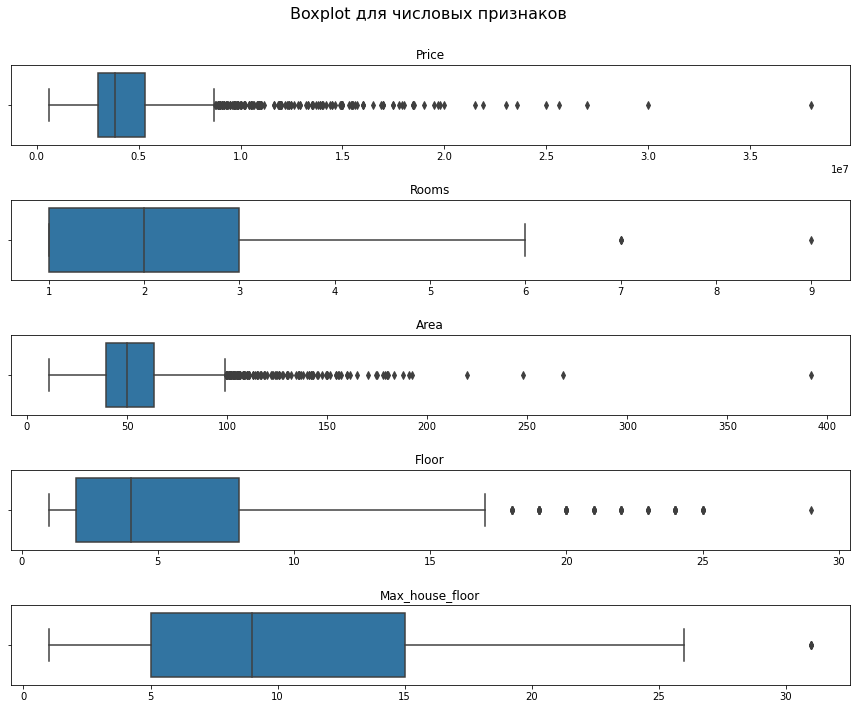

In [20]:
fig, axes = plt.subplots(5, 1, figsize=(12,10))
fig.suptitle('Boxplot для числовых признаков', fontsize=16)

for i, column in zip(range(5), df.describe().columns):
    sns.boxplot(x=column, data=df, ax=axes[i])
    axes[i].set_xlabel('')
    axes[i].set_title(column)
    
fig.tight_layout()
fig.subplots_adjust(top=0.9)

In [21]:
df = df.drop(labels=df[df['Price'] > 20000000].index)
df = df.drop(labels=df[df['Year_built'] < 1750].index)
df = df.drop(labels=df[df['Area'] > 200].index)
df = df.reset_index(drop=True)

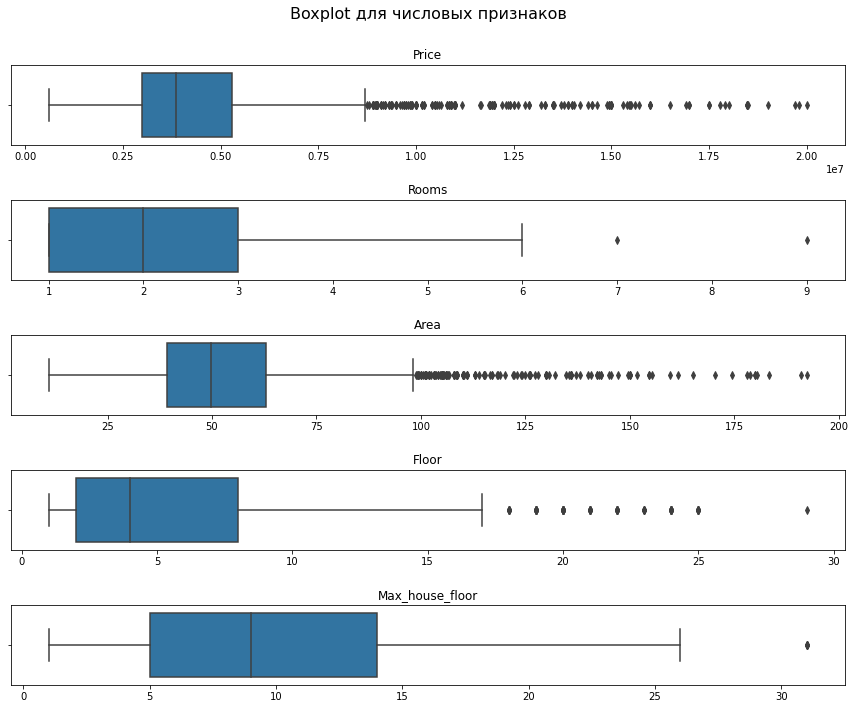

In [22]:
fig, axes = plt.subplots(5, 1, figsize=(12,10))
fig.suptitle('Boxplot для числовых признаков', fontsize=16)

for i, column in zip(range(5), df.describe().columns):
    sns.boxplot(x=column, data=df, ax=axes[i])
    axes[i].set_xlabel('')
    axes[i].set_title(column)
    
fig.tight_layout()
fig.subplots_adjust(top=0.9)

Квартиры с площадью менее 14 действительно являются квартирами, а не комнатами, либо другими объектами недвижимости.

In [23]:
for i in df[df['Area'] < 14].Link:
    print(i)

https://www.avito.ru/perm/kvartiry/1-k._kvartira_131m_15et._2392843232
https://www.avito.ru/perm/kvartiry/1-k._kvartira_13m_55et._2373531241
https://www.avito.ru/perm/kvartiry/kvartira-studiya_12m_29et._2373471328
https://www.avito.ru/perm/kvartiry/1-k._kvartira_11m_15et._2308903070
https://www.avito.ru/perm/kvartiry/kvartira-studiya_13m_19et._2089711644
https://www.avito.ru/perm/kvartiry/1-k._kvartira_12m_19et._2366809019
https://www.avito.ru/perm/kvartiry/1-k._kvartira_12m_19et._2371906724
https://www.avito.ru/perm/kvartiry/kvartira-studiya_13m_29et._2353990291
https://www.avito.ru/perm/kvartiry/1-k._kvartira_137m_15et._2330813172
https://www.avito.ru/perm/kvartiry/kvartira-studiya_109m_29et._2340122723
https://www.avito.ru/perm/kvartiry/kvartira-studiya_13m_29et._2207266543
https://www.avito.ru/perm/kvartiry/kvartira-studiya_13m_19et._2079943229


#### Оценка готовности данных к построению модели

На 3d графике наблюдается зависимость цены от использованных в графике признаков. Визуально можно наблюдать увеличение цены с повышением года постройки, не смотря на одинаковое количество комнат. И увеличение цены в зависимости от площади.

Ошибочных данных датасет не имеет, сильно аномальные значения были исключены. Данные готовы к построению модели.

<IPython.core.display.Javascript object>


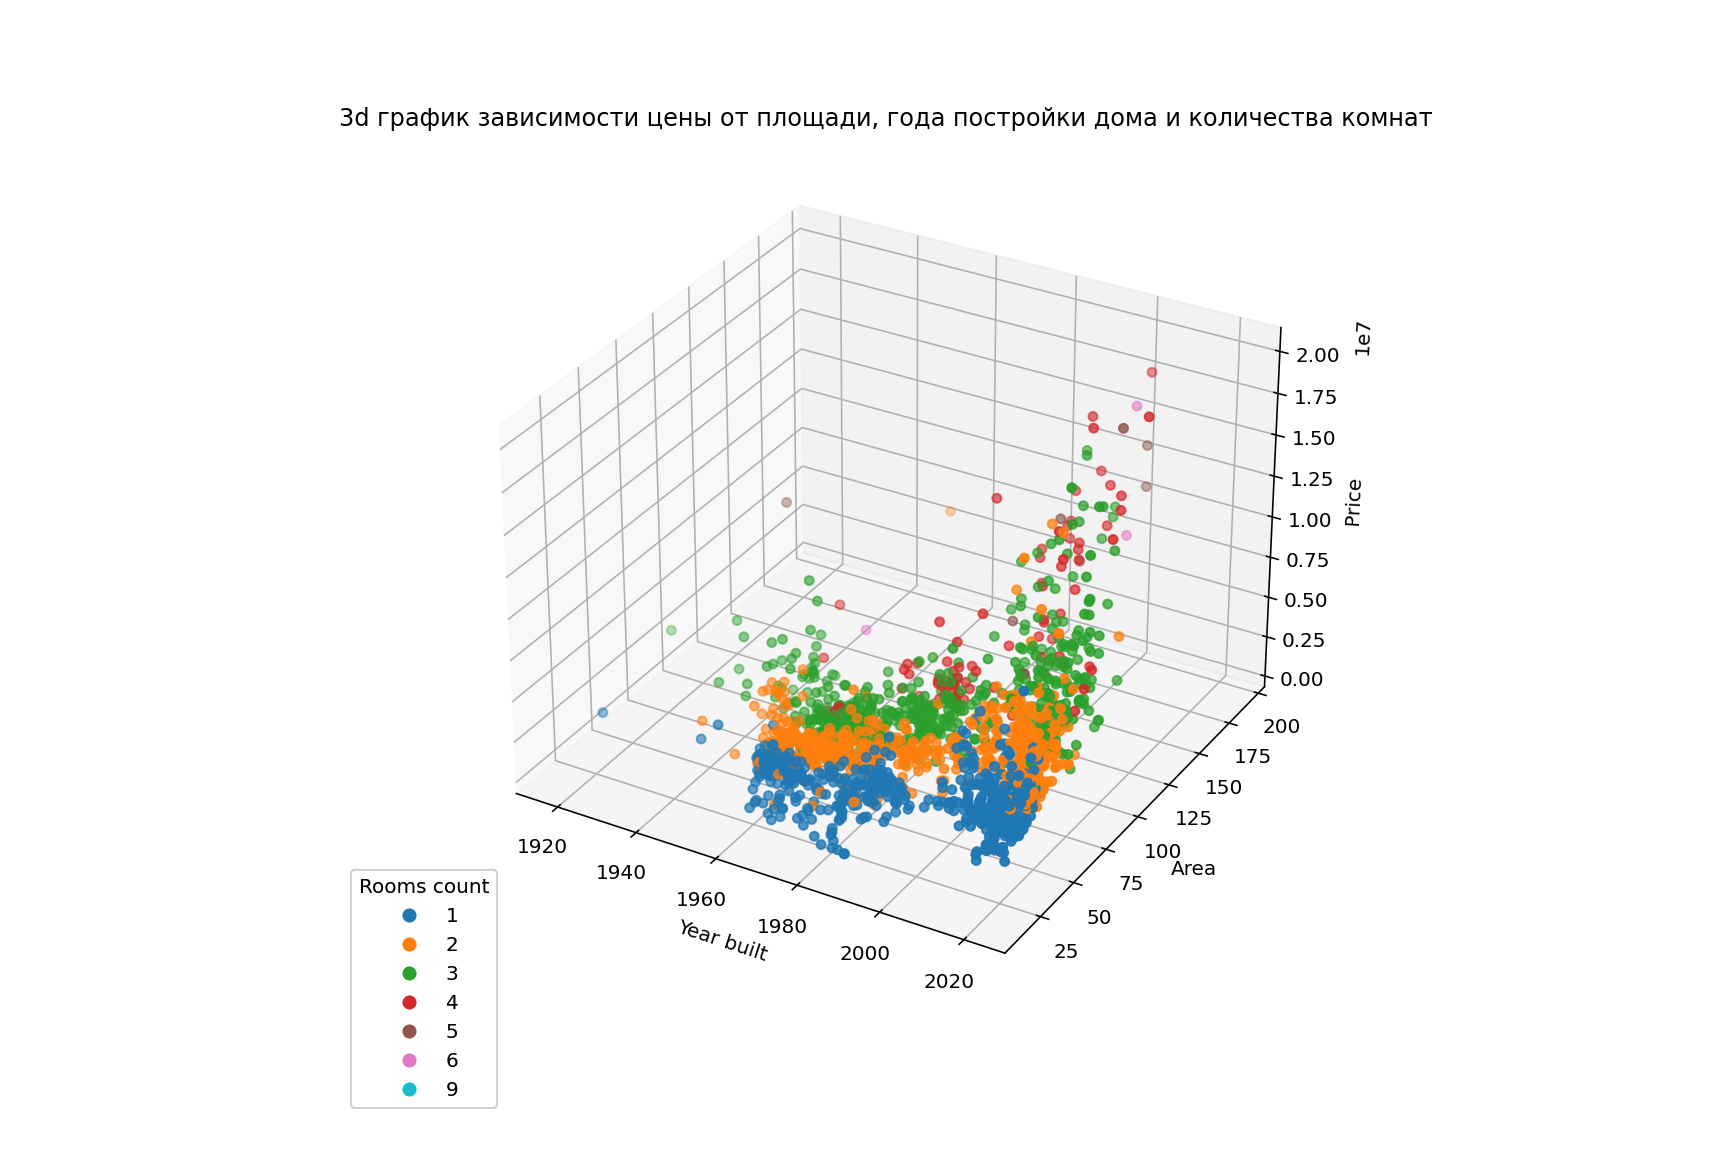

In [24]:
%matplotlib notebook
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')
g = ax.scatter(df.Year_built, df.Area, df.Price, c=df.Rooms, cmap='tab10')
ax.set_title('3d график зависимости цены от площади, года постройки дома и количества комнат', fontsize=12)
ax.set_xlabel('Year built')
ax.set_ylabel('Area')
ax.set_zlabel('Price')
legend = ax.legend(*g.legend_elements(), loc="lower left", title="Rooms count", borderaxespad=-5, ncol=1)
ax.add_artist(legend)
plt.show()

___
### Построение модели для прогнозирования цены

Для построения простой линейной модели со всеми признаками потребуется следующее: 
- отобрать все признаки со строками без NaN значений;
- конвертировать категориальные переменные в дамми-переменные.

Итоговая размерность датафрейма (1479, 17).

In [25]:
df.head()

,Price,Rooms,Area,Floor,Max_house_floor,balcony_or_loggia,Bathroom,Year_built,District,Link
0,3250000,2,40.0,9,25,балкон,совмещенный,2016.0,Орджоникидзевский,https://www.avito.ru/perm/kvartiry/2-k._kvarti...
1,7017200,2,58.8,20,25,балкон,раздельный,2021.0,Индустриальный,https://www.avito.ru/perm/kvartiry/2-k._kvarti...
2,7600000,2,60.0,14,25,NaN,раздельный,2013.0,Свердловский,https://www.avito.ru/perm/kvartiry/2-k._kvarti...
3,7500000,3,95.0,4,16,NaN,NaN,NaN,Дзержинский,https://www.avito.ru/perm/kvartiry/3-k._kvarti...
4,2399000,1,36.0,1,9,NaN,раздельный,1986.0,Свердловский,https://www.avito.ru/perm/kvartiry/1-k._kvarti...


In [26]:
print('Кол-во строк со всеми признаками:', 
      df[['Bathroom', 'balcony_or_loggia', 'Year_built']] \
     .isna() \
     .query('Bathroom == False & balcony_or_loggia == False & Year_built == False') \
     .shape[0])

Кол-во строк со всеми признаками: 1479


In [27]:
df_all_features = df[df['balcony_or_loggia'].notna() \
                     & df['Bathroom'].notna() \
                     & df['Year_built'].notna()]
df_all_features = df_all_features.reset_index(drop=True)
df_all_features = df_all_features.drop(columns='Link')

df_all_features = pd.get_dummies(df_all_features)

print(df_all_features.shape)
df_all_features.tail()

(1479, 17)


,Price,Rooms,Area,Floor,Max_house_floor,Year_built,balcony_or_loggia_балкон,balcony_or_loggia_лоджия,Bathroom_раздельный,Bathroom_совмещенный,District_Дзержинский,District_Индустриальный,District_Кировский,District_Ленинский,District_Мотовилихинский,District_Орджоникидзевский,District_Свердловский
1474,7600000,3,88.0,12,19,2020.0,0,1,0,1,1,0,0,0,0,0,0
1475,3990000,3,55.9,8,14,1983.0,0,1,1,0,0,0,0,0,1,0,0
1476,12000000,4,130.0,6,9,2005.0,0,1,1,0,0,0,0,0,0,0,1
1477,4300000,3,68.0,9,10,2000.0,1,0,1,0,0,0,0,0,1,0,0
1478,4000000,3,61.7,3,5,1977.0,1,0,1,0,0,0,0,0,0,1,0


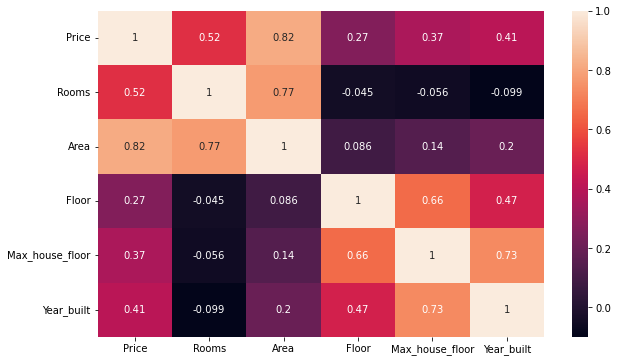

In [28]:
# Area и Rooms, Year_built и Max_house_floor сильно коррелируют между собой
# для линейной модели это может ухудшить качество модели.
%matplotlib inline

plt.figure(figsize=(10, 6))
sns.heatmap(df_all_features.iloc[:, :6].corr(), annot=True)
plt.show()

#### Линейная модель со всеми признаками, без масштабирования

Линейная регрессия показывает хороший результат, коэффициент детерминации более 0.8, что говорит о хорошей прогнозной способности, однако R<sup>2</sup> на тренировочном меньше, чем на тестовом, что, возможно говорит о недообучении модели, либо таком "удачном" сплите. 

Коэффициенты при уравнении гребневой регрессии почти аналогичны простой линейной регресии. Получается, что объема обучающих данных достаточно и регуляризация становится менее важной, поэтому будет демонстрироваться одинаковое качество работ. Значит надо идти в сторону усложнения модели, а не в сторону борьбы с переобучением и увеличению обощающей способности.

Варианты доработки модели: масштабировать данные с `RobustScaler()`, сгенерировать полиномы с `PolinomialFeatures()`, подогнать признаки к нормальному распределению с помощью `np.log()`.

С масштабированием, возможно, не так эффективно используются дамми переменные. Но если все масштабировать не в контейнере, то кросс-валидация будет неверна использоваться с более позитивными результатами из-за утечки данных.

Построение полиномов признаков дает положительный результат, но при этом все еще тестовый результат лучше, чем тренировочный.

Использую другие более сложные модели, такие как `SVR()` и `RandomForestRegression()`.

`SVR()` демонстрирует работу модели лучше, чем линейная, однако можно все еще улучшить линейную модель, подогнав признаки к нормальному распределению.

Усложненная линейная модель показывает хорошее качество работу, достаточное для дальнейшего использования.
Уменьшать количество признаков и увеличивать количество строк смысла нет, так как в таких обьектах будут уже играть роль различные признаки, которые не парсились (ремонт, расстояние до центра (остановки, магазинов, школ, детсадов) и тд). Без этих признаков модель не сможет показать хорошие результаты.

In [29]:
X = df_all_features.drop(columns='Price')
y = df_all_features.Price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

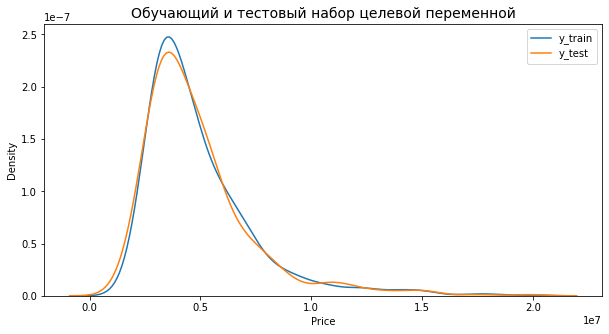

In [30]:
# Данные сплитнулись без видимых отклонений тестового и трейнового множеств
plt.figure(figsize=(10,5))
sns.kdeplot(y_train)
sns.kdeplot(y_test)
plt.title('Обучающий и тестовый набор целевой переменной', fontsize=14)
plt.legend(['y_train', 'y_test'])
plt.show()

In [31]:
# Простая линейная модель
param_grid = {'n_jobs': [-1]}
grid_line = GridSearchCV(LinearRegression(), param_grid, cv=5)
grid_line.fit(X_train, y_train)

print(f'Linear R^2 на тренировочном: {grid_line.score(X_train, y_train):.4f}')
print(f'Linear R^2 на тестовом: {grid_line.score(X_test, y_test):.4f}')

Linear R^2 на тренировочном: 0.8221
Linear R^2 на тестовом: 0.8398


In [32]:
# Модель Ridge
param_grid = {'alpha': np.logspace(-3, 3, num=50)}
grid_ridge = GridSearchCV(Ridge(), param_grid, cv=5)
grid_ridge.fit(X_train, y_train)
print(grid_ridge.best_estimator_)
print()
print('Сравнение коэффициентов обычной линейной регрессии и Ridge:')
for coef_line, coef_ridge, column in zip(grid_line.best_estimator_.coef_, grid_ridge.best_estimator_.coef_, X.columns):
    print(f'{column:<26} | {coef_line:<10.1f} | {coef_ridge:.1f}')
print()
print(f'Ridge R^2 на тренировочном: {grid_ridge.score(X_train, y_train):.4f}')
print(f'Ridge R^2 на тестовом: {grid_ridge.score(X_test, y_test):.4f}')

Ridge(alpha=1.5264179671752334)

Сравнение коэффициентов обычной линейной регрессии и Ridge:
Rooms                      | -322919.2  | -321194.6
Area                       | 96255.7    | 96302.8
Floor                      | 31281.0    | 31388.9
Max_house_floor            | 12504.0    | 12606.6
Year_built                 | 21980.1    | 21871.8
balcony_or_loggia_балкон   | 38948.9    | 37107.1
balcony_or_loggia_лоджия   | -38948.9   | -37107.1
Bathroom_раздельный        | -202555.4  | -203064.6
Bathroom_совмещенный       | 202555.4   | 203064.6
District_Дзержинский       | 193103.2   | 194385.7
District_Индустриальный    | 104729.2   | 107279.5
District_Кировский         | -932901.6  | -913923.8
District_Ленинский         | 1767924.3  | 1715999.4
District_Мотовилихинский   | -192471.9  | -186600.0
District_Орджоникидзевский | -1289569.1 | -1266687.2
District_Свердловский      | 349186.1   | 349546.4

Ridge R^2 на тренировочном: 0.8220
Ridge R^2 на тестовом: 0.8398


In [33]:
# Линейная модель с масштабированием
pipe_linear = make_pipeline(RobustScaler(), LinearRegression())
parameters_linear = {'linearregression__n_jobs': [-1]}
grid_linear_scaled = GridSearchCV(pipe_linear, parameters_linear, cv=5)
grid_linear_scaled.fit(X_train, y_train)
grid_linear_scaled.score(X_train, y_train)
grid_linear_scaled.score(X_test, y_test)

print(f'Linear scaled R^2 на тренировочном: {grid_linear_scaled.score(X_train, y_train):.4f}')
print(f'Linear scaled R^2 на тестовом: {grid_linear_scaled.score(X_test, y_test):.4f}')

Linear scaled R^2 на тренировочном: 0.8220
Linear scaled R^2 на тестовом: 0.8400


In [34]:
# Линейная модель с масштабированием и сгенерированными полиномами
pipe_linear_poly = make_pipeline(PolynomialFeatures(2), RobustScaler(), LinearRegression())
parameters_linear = {'linearregression__n_jobs': [-1]}
grid_linear_poly = GridSearchCV(pipe_linear_poly, parameters_linear, cv=5)
grid_linear_poly.fit(X_train, y_train)
grid_linear_poly.score(X_train, y_train)
grid_linear_poly.score(X_test, y_test)

print(f'Linear scaled and poly R^2 на тренировочном: {grid_linear_poly.score(X_train, y_train):.4f}')
print(f'Linear scaled and poly R^2 на тестовом: {grid_linear_poly.score(X_test, y_test):.4f}')

Linear scaled and poly R^2 на тренировочном: 0.8631
Linear scaled and poly R^2 на тестовом: 0.8693


In [ ]:
# Модель SVR
pipe_linear_svr = make_pipeline(RobustScaler(), SVR())
parameters_svr = {'svr__C': np.logspace(-3, 9, num=20), 'svr__gamma': np.logspace(-3, 3, num=10)}
grid_svr = GridSearchCV(pipe_linear_svr, parameters_svr, cv=5)
grid_svr.fit(X_train, y_train)
grid_svr.score(X_train, y_train)
grid_svr.score(X_test, y_test)

print('SVR R^2 на тренировочном:', grid_svr.score(X_train, y_train))
print('SVR R^2 на тестовом:', grid_svr.score(X_test, y_test))
print(grid_svr.best_estimator_[1])

# SVR R^2 на тренировочном: 0.893614574918631
# SVR R^2 на тестовом: 0.8731746134246017
# SVR(C=1000000000.0, gamma=0.03162277660168379)

RFR R^2 на тренировочном: 0.9502
RFR R^2 на тестовом: 0.8498
RandomForestRegressor(max_depth=9, n_estimators=500, n_jobs=-1)


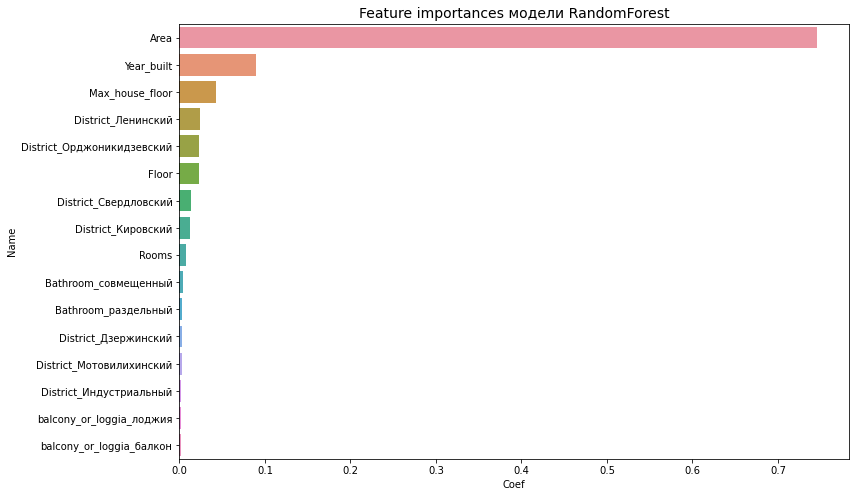

In [35]:
# Модель RandomForestRegressor
param_grid_rf = {'n_estimators': [500], 'max_depth': range(2, 11), 'n_jobs': [-1]}
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=5)
grid_rf.fit(X_train, y_train)

print(f'RFR R^2 на тренировочном: {grid_rf.score(X_train, y_train):.4f}')
print(f'RFR R^2 на тестовом: {grid_rf.score(X_test, y_test):.4f}')
print(grid_rf.best_estimator_)

df_forest = pd.DataFrame({'Name': X.columns, 'Coef': grid_rf.best_estimator_.feature_importances_}).sort_values(by='Coef', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(y='Name', x='Coef', data=df_forest)
plt.title('Feature importances модели RandomForest', fontsize=14)
plt.show()

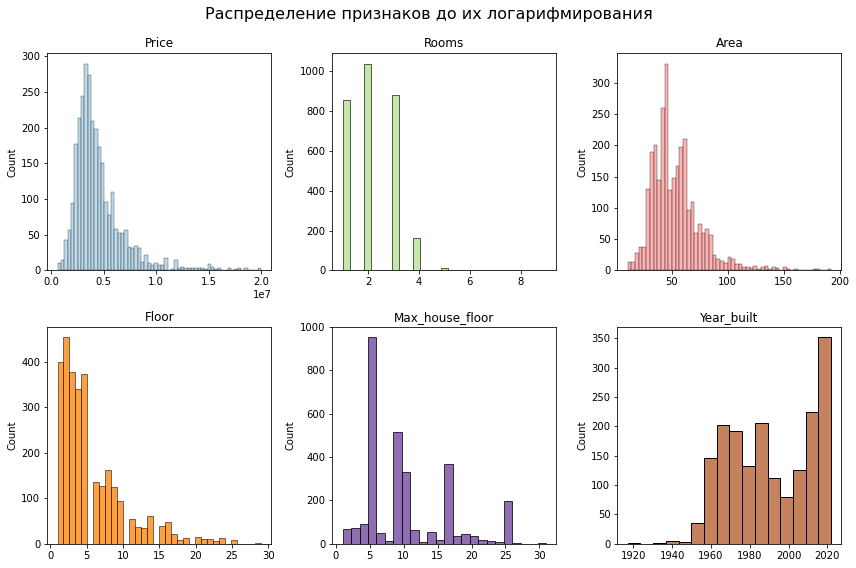

In [36]:
fig, axes = plt.subplots(2, 3, figsize=(12,8))
fig.suptitle('Распределение признаков до их логарифмирования', fontsize=16)

color_i = 0
for ax, column in zip(axes.flatten(), df.describe().columns):
    sns.histplot(x=column, data=df, ax=ax, color=plt.cm.Paired(color_i/10.))
    ax.set_xlabel('')
    ax.set_title(column)
    color_i += 2

fig.tight_layout()
fig.subplots_adjust(top=0.9)

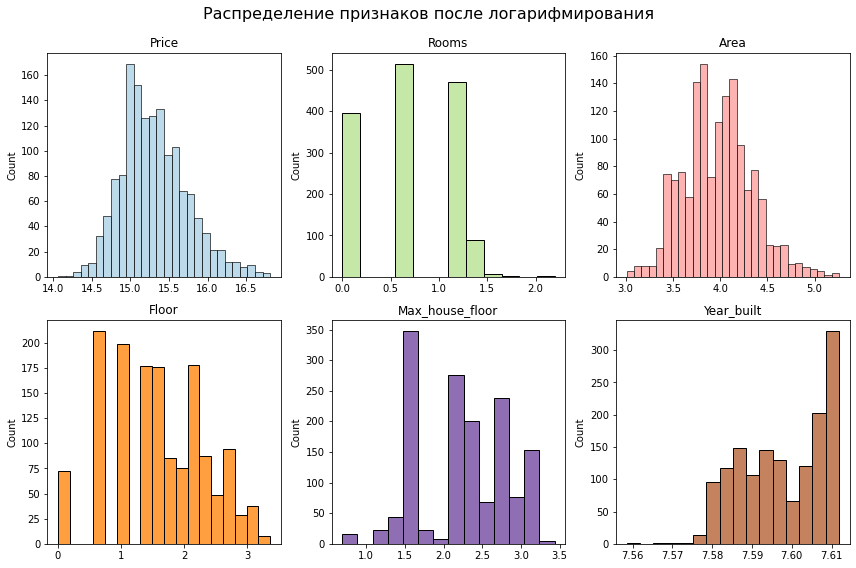

In [37]:
df_log = df_all_features.copy()
for column in df_log.columns[:6]:
    df_log[column] = np.log(df_log[column])

fig, axes = plt.subplots(2, 3, figsize=(12,8))
fig.suptitle('Распределение признаков после логарифмирования', fontsize=16)

color_i = 0
for ax, column in zip(axes.flatten(), df_log.describe().columns):
    sns.histplot(x=column, data=df_log, ax=ax, color=plt.cm.Paired(color_i/10.))
    ax.set_xlabel('')
    ax.set_title(column)
    color_i += 2
    
fig.tight_layout()
fig.subplots_adjust(top=0.9)

In [38]:
X_log = df_log.drop(columns='Price')
y_log = df_log.Price
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size=0.33, random_state=42)

pipe_linear_poly = make_pipeline(PolynomialFeatures(2), RobustScaler(), LinearRegression())
parameters_linear = {'linearregression__n_jobs': [-1]}
grid_linear = GridSearchCV(pipe_linear_poly, parameters_linear, cv=5)
grid_linear.fit(X_train_log, y_train_log)

print(f'Linear R^2 на тренировочном: {grid_linear.score(X_train_log, y_train_log):.4f}')
print(f'Linear R^2 на тестовом: {grid_linear.score(X_test_log, y_test_log):.4f}')

Linear R^2 на тренировочном: 0.8751
Linear R^2 на тестовом: 0.8770


#### Построение модели для отправки link  на похожие объекты

Для отправки похожих объектов недвижимости буду использовать `KNeighborsRegressor()`. 

Модель с 7 ближайшими соседями достаточно качественная. Также полученные объекты-соседи можно будет дополнительно отфильтровать на этапе отправки модели (допустим добавив границу стоимости объекта ±400тыс.руб).

In [39]:
scores_data = pd.DataFrame()
pipe_neighbor = make_pipeline(RobustScaler(), KNeighborsRegressor())
for i in range(1, 40):
    parameters_neighbor = {'kneighborsregressor__n_neighbors': [i]}
    grid_neighbor = GridSearchCV(pipe_neighbor, parameters_neighbor, cv=5)
    grid_neighbor.fit(X_train, y_train)
    train_score = grid_neighbor.score(X_train, y_train)
    test_score = grid_neighbor.score(X_test, y_test)
    temp_score_data = pd.DataFrame({'n_neighbors': [i], 'train_score': [train_score], 'test_score': [test_score]})
    scores_data = pd.concat([scores_data, temp_score_data], ignore_index=True)

<AxesSubplot:xlabel='n_neighbors'>

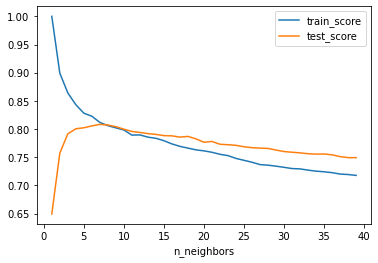

In [40]:
scores_data.plot(x='n_neighbors', y=['train_score', 'test_score'])

In [41]:
scores_data.sort_values(by='test_score', ascending=False).head()

,n_neighbors,train_score,test_score
6,7,0.811805,0.808306
7,8,0.806021,0.807174
5,6,0.822736,0.805631
8,9,0.802146,0.804258
4,5,0.828206,0.802260


In [42]:
pipe_neighbor = make_pipeline(RobustScaler(), KNeighborsRegressor())
parameters_neighbor = {'kneighborsregressor__n_neighbors': [7]}
grid_neighbor = GridSearchCV(pipe_neighbor, parameters_neighbor, cv=5)
grid_neighbor.fit(X_train, y_train)

print(f'KNR R^2 на тренировочном: {grid_neighbor.score(X_train, y_train):.4f}')
print(f'KNR R^2 на тестовом: {grid_neighbor.score(X_test, y_test):.4f}')

KNR R^2 на тренировочном: 0.8118
KNR R^2 на тестовом: 0.8083


#### Сохранение моделей и рабочего датасета

In [43]:
with open('model_price.pkl','wb') as f:
    pickle.dump(grid_linear,f)
with open('model_links.pkl','wb') as f:
    pickle.dump(grid_neighbor,f)

In [44]:
df_all_features.to_csv('df_all_features.csv', encoding='utf-8')

In [45]:
df_with_links = df[df['balcony_or_loggia'].notna() \
                     & df['Bathroom'].notna() \
                     & df['Year_built'].notna()]
df_with_links = df_with_links.reset_index(drop=True)
df_with_links.to_csv('database_with_links.csv', encoding='utf-8')